<a href="https://colab.research.google.com/github/syedayazsa/transfer-learning-for-segregation/blob/master/VGG16_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING NECESSARY LIBRARIES**

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


# **LOADING AND UNZIPPING THE DATASET**

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-05-16 13:44:55--  https://docs.google.com/uc?export=download&confirm=JruQ&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 74.125.200.139, 74.125.200.102, 74.125.200.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.200.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-7k-docs.googleusercontent.com/docs/securesc/ba0fb5coqfeuhotke7q2cvbvtib359ec/p2igqg60q134uo2usjvv9ojih5bfti8g/1589636625000/14211000813324722452/13113306532138207340Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-05-16 13:44:55--  https://doc-04-7k-docs.googleusercontent.com/docs/securesc/ba0fb5coqfeuhotke7q2cvbvtib359ec/p2igqg60q134uo2usjvv9ojih5bfti8g/1589636625000/14211000813324722452/13113306532138207340Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-04-7k-docs.googleusercontent.com (doc-04-7k-docs.googleusercontent.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting

In [0]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottles/img (690).jpg  
  inflating: split_dataset/train/bottle

# **SPECIFIYING PATHS TO DIRECTORY**

In [0]:
base_path = '/content/split_dataset'

folders = glob('/content/split_dataset/train/*')
print(folders)

['/content/split_dataset/train/automatic_rifles', '/content/split_dataset/train/boots', '/content/split_dataset/train/pistol_revolver', '/content/split_dataset/train/band-aid', '/content/split_dataset/train/syringes', '/content/split_dataset/train/knives', '/content/split_dataset/train/bottles', '/content/split_dataset/train/bullet_shells']


In [0]:
IMAGE_SIZE = [224, 224]

train_path = '/content/split_dataset/train'
valid_path = '/content/split_dataset/validation'

# **PREPARING THE PRE-TRAINED VGG**

In [0]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 6s 0us/step


In [0]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

# **CREATING THE VGG MODEL**

In [0]:
model_vgg = Model(inputs=vgg.input, outputs=prediction)
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
model_vgg.compile(
  loss='categorical_crossentropy',
  optimizer= 'adam',
  metrics=['accuracy']
)

# **USING IMAGE AUGMENTATION**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
    
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

training_set = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/split_dataset/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


In [0]:
history_vgg = model_vgg.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=100,
  verbose = 1,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/30
  2/203 [..............................] - ETA: 2:54 - loss: 2.8675 - accuracy: 0.1562

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


203/203 [==============================] - 113s 557ms/step - loss: 0.5283 - accuracy: 0.8304 - val_loss: 0.1154 - val_accuracy: 0.9237
Epoch 2/30
203/203 [==============================] - 108s 531ms/step - loss: 0.2896 - accuracy: 0.9060 - val_loss: 0.1100 - val_accuracy: 0.9428
Epoch 3/30
203/203 [==============================] - 107s 529ms/step - loss: 0.2469 - accuracy: 0.9222 - val_loss: 0.1927 - val_accuracy: 0.9292
Epoch 4/30
203/203 [==============================] - 108s 530ms/step - loss: 0.2603 - accuracy: 0.9161 - val_loss: 0.1862 - val_accuracy: 0.9415
Epoch 5/30
203/203 [==============================] - 107s 529ms/step - loss: 0.2190 - accuracy: 0.9279 - val_loss: 0.6144 - val_accuracy: 0.9255
Epoch 6/30
203/203 [==============================] - 107s 529ms/step - loss: 0.2059 - accuracy: 0.9349 - val_loss: 0.5612 - val_accuracy: 0.9483
Epoch 7/30
203/203 [==============================] - 107s 529ms/step - loss: 0.2272 - accuracy: 0.9327 - val_loss: 0.9582 - val_accura

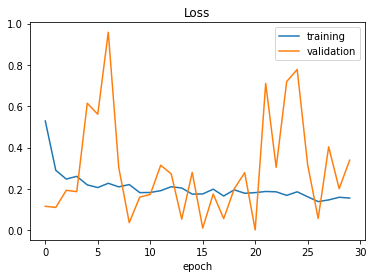

In [0]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

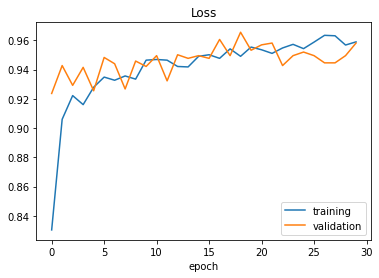

In [0]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [0]:
model_vgg.save('vgg.h5')
from google.colab import files
files.download('vgg.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 53688, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# **Training after dropout and & no augmentation on validation data**

In [0]:
history_vgg_2 = model_vgg.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=30,
  verbose = 1,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/30
 34/203 [====>.........................] - ETA: 1:55 - loss: 1.2899 - accuracy: 0.5717

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


203/203 [==============================] - 125s 615ms/step - loss: 0.6065 - accuracy: 0.8039 - val_loss: 0.5817 - val_accuracy: 0.9132
Epoch 2/30
203/203 [==============================] - 112s 552ms/step - loss: 0.3600 - accuracy: 0.8840 - val_loss: 0.3276 - val_accuracy: 0.9348
Epoch 3/30
203/203 [==============================] - 114s 561ms/step - loss: 0.3162 - accuracy: 0.8991 - val_loss: 0.1633 - val_accuracy: 0.9255
Epoch 4/30
203/203 [==============================] - 113s 559ms/step - loss: 0.3082 - accuracy: 0.9057 - val_loss: 0.0382 - val_accuracy: 0.9348
Epoch 5/30
203/203 [==============================] - 115s 567ms/step - loss: 0.3255 - accuracy: 0.9034 - val_loss: 0.1831 - val_accuracy: 0.9434
Epoch 6/30
203/203 [==============================] - 115s 566ms/step - loss: 0.3148 - accuracy: 0.9057 - val_loss: 0.3174 - val_accuracy: 0.9298
Epoch 7/30
203/203 [==============================] - 115s 565ms/step - loss: 0.3015 - accuracy: 0.9161 - val_loss: 0.2775 - val_accura

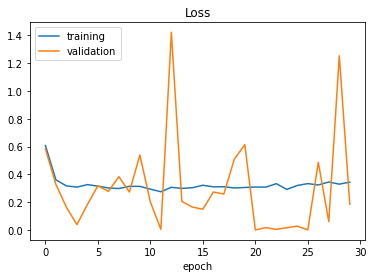

In [0]:
plt.plot(history_vgg_2.history['loss'])
plt.plot(history_vgg_2.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

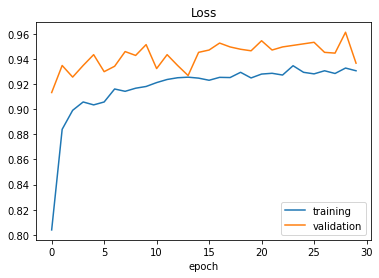

In [0]:
plt.plot(history_vgg_2.history['accuracy'])
plt.plot(history_vgg_2.history['val_accuracy'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

# **TRAINING AFTER VALIDATION DATA AUGMENTATION**

In [0]:
history_vgg_3 = model_vgg.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=30,
  verbose = 1,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/30
  3/203 [..............................] - ETA: 3:05 - loss: 0.6185 - accuracy: 0.8854

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


203/203 [==============================] - 125s 617ms/step - loss: 0.3030 - accuracy: 0.9361 - val_loss: 0.1166 - val_accuracy: 0.9206
Epoch 2/30
203/203 [==============================] - 119s 586ms/step - loss: 0.3172 - accuracy: 0.9326 - val_loss: 0.3614 - val_accuracy: 0.9268
Epoch 3/30
203/203 [==============================] - 123s 607ms/step - loss: 0.3102 - accuracy: 0.9353 - val_loss: 1.1988 - val_accuracy: 0.9145
Epoch 4/30
203/203 [==============================] - 121s 595ms/step - loss: 0.3065 - accuracy: 0.9352 - val_loss: 0.0030 - val_accuracy: 0.9169
Epoch 5/30
203/203 [==============================] - 118s 582ms/step - loss: 0.3268 - accuracy: 0.9353 - val_loss: 0.3200 - val_accuracy: 0.9108
Epoch 6/30
203/203 [==============================] - 118s 580ms/step - loss: 0.3318 - accuracy: 0.9350 - val_loss: 1.5562 - val_accuracy: 0.9194
Epoch 7/30
203/203 [==============================] - 117s 576ms/step - loss: 0.3041 - accuracy: 0.9380 - val_loss: 0.0242 - val_accura

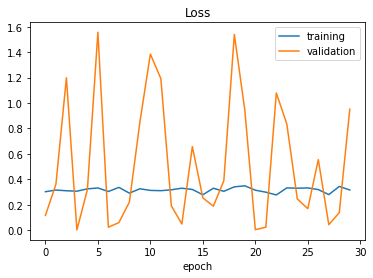

In [0]:
plt.plot(history_vgg_3.history['loss'])
plt.plot(history_vgg_3.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

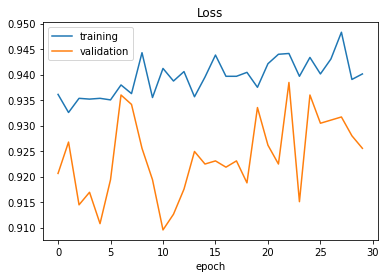

In [0]:
plt.plot(history_vgg_3.history['accuracy'])
plt.plot(history_vgg_3.history['val_accuracy'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

# **REMOVING DROPOUT, REDUCING LEARNING RATE TO 0.001 FROM 0.01**

In [0]:
history_vgg_4 = model_vgg.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=30,
  verbose = 1,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/30
  9/203 [>.............................] - ETA: 3:38 - loss: 2.6803 - accuracy: 0.2049

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


203/203 [==============================] - 135s 667ms/step - loss: 0.5539 - accuracy: 0.8185 - val_loss: 0.2740 - val_accuracy: 0.8517
Epoch 2/30
203/203 [==============================] - 122s 600ms/step - loss: 0.2725 - accuracy: 0.9070 - val_loss: 0.7501 - val_accuracy: 0.8689
Epoch 3/30
203/203 [==============================] - 126s 621ms/step - loss: 0.2501 - accuracy: 0.9250 - val_loss: 0.5773 - val_accuracy: 0.8658
Epoch 4/30
203/203 [==============================] - 126s 622ms/step - loss: 0.2562 - accuracy: 0.9208 - val_loss: 0.3384 - val_accuracy: 0.8837
Epoch 5/30
203/203 [==============================] - 120s 593ms/step - loss: 0.2297 - accuracy: 0.9275 - val_loss: 0.1400 - val_accuracy: 0.9132
Epoch 6/30
203/203 [==============================] - 119s 584ms/step - loss: 0.2313 - accuracy: 0.9292 - val_loss: 0.3655 - val_accuracy: 0.8843
Epoch 7/30
203/203 [==============================] - 118s 582ms/step - loss: 0.2079 - accuracy: 0.9332 - val_loss: 0.8824 - val_accura

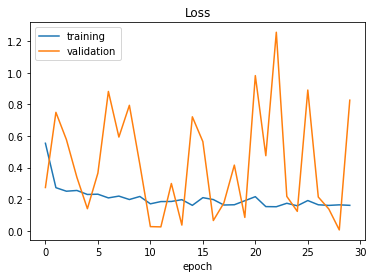

In [0]:
plt.plot(history_vgg_4.history['loss'])
plt.plot(history_vgg_4.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

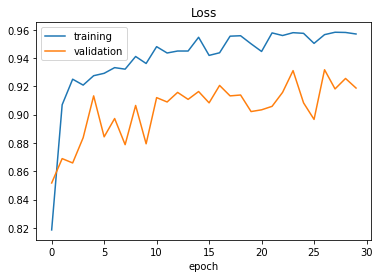

In [0]:
plt.plot(history_vgg_4.history['accuracy'])
plt.plot(history_vgg_4.history['val_accuracy'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

# **CHANGING BATCH SIZE TO 20, LEARNING RATE TO 0.005, AND TINKERING THE TRAINING AND VALIDATION STEPS**

In [0]:
history_vgg = model_vgg.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=50,
  verbose = 1,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


203/203 [==============================] - 128s 629ms/step - loss: 0.6499 - accuracy: 0.9480 - val_loss: 0.8413 - val_accuracy: 0.9034
Epoch 2/100
203/203 [==============================] - 116s 571ms/step - loss: 0.5549 - accuracy: 0.9523 - val_loss: 2.2166 - val_accuracy: 0.9194
Epoch 3/100
203/203 [==============================] - 117s 576ms/step - loss: 0.4990 - accuracy: 0.9549 - val_loss: 1.2812 - val_accuracy: 0.9249
Epoch 4/100
203/203 [==============================] - 118s 580ms/step - loss: 0.5101 - accuracy: 0.9554 - val_loss: 3.0917e-04 - val_accuracy: 0.9255
Epoch 5/100
203/203 [==============================] - 117s 577ms/step - loss: 0.4259 - accuracy: 0.9582 - val_loss: 1.1510 - val_accuracy: 0.9120
Epoch 6/100
203/203 [==============================] - 117s 578ms/step - loss: 0.5037 - accuracy: 0.9529 - val_loss: 3.1207 - val_accuracy: 0.9071
Epoch 7/100
203/203 [==============================] - 117s 578ms/step - loss: 0.4131 - accuracy: 0.9586 - val_loss: 0.9086 - 

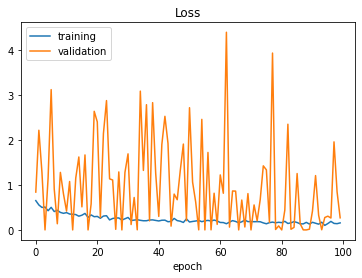

In [0]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

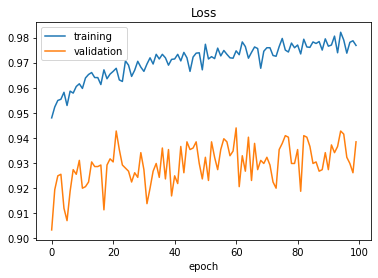

In [0]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [0]:
history_vgg = model_vgg.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=50,
  verbose = 1,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
)

Epoch 1/50
  5/203 [..............................] - ETA: 2:28 - loss: 0.0591 - accuracy: 0.9937

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


203/203 [==============================] - 127s 624ms/step - loss: 0.1184 - accuracy: 0.9826 - val_loss: 0.0024 - val_accuracy: 0.9255
Epoch 2/50
203/203 [==============================] - 122s 599ms/step - loss: 0.1477 - accuracy: 0.9779 - val_loss: 4.3686 - val_accuracy: 0.9212
Epoch 3/50
203/203 [==============================] - 121s 597ms/step - loss: 0.1310 - accuracy: 0.9779 - val_loss: 3.3095 - val_accuracy: 0.9378
Epoch 4/50
203/203 [==============================] - 122s 603ms/step - loss: 0.1572 - accuracy: 0.9789 - val_loss: 1.3911 - val_accuracy: 0.9292
Epoch 5/50
203/203 [==============================] - 122s 603ms/step - loss: 0.1485 - accuracy: 0.9784 - val_loss: 0.0037 - val_accuracy: 0.9348
Epoch 6/50
203/203 [==============================] - 120s 590ms/step - loss: 0.1771 - accuracy: 0.9745 - val_loss: 1.4220 - val_accuracy: 0.9280
Epoch 7/50
203/203 [==============================] - 119s 587ms/step - loss: 0.1613 - accuracy: 0.9769 - val_loss: 0.2649 - val_accura

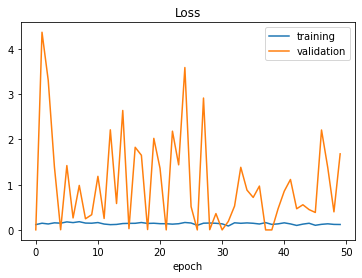

In [0]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

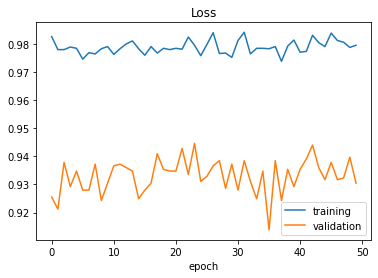

In [0]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [0]:
model_vgg.save('vgg.h5')
from google.colab import files
files.download('vgg.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 34172, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil